In [1]:
import scanpy as sc
import pandas as pd
import scvelo as scv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn


In [2]:
crypto_1 = sc.read('../../../Data/notebooks_data/crypto_1.h5ad')

In [3]:
MT = ['MT' in i for i in crypto_1.var_names]
perc_mito = np.sum( crypto_1[:,MT].X, 1 ) / np.sum( crypto_1.X, 1 )
crypto_1.obs['perc_mito'] = perc_mito.copy()

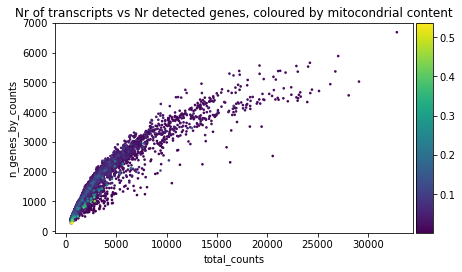

In [4]:
sc.pl.scatter(crypto_1, x='total_counts', y='n_genes_by_counts', color='perc_mito', 
              title ='Nr of transcripts vs Nr detected genes, coloured by mitocondrial content')

<AxesSubplot:xlabel='total_counts', ylabel='Density'>

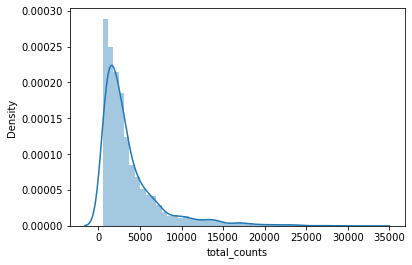

In [5]:
sns.distplot(crypto_1.obs['total_counts'], bins=50)

<AxesSubplot:xlabel='n_genes_by_counts', ylabel='Density'>

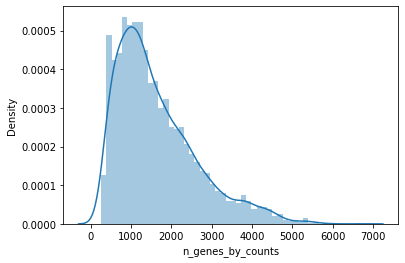

In [6]:
sns.distplot(crypto_1.obs['n_genes_by_counts'], bins=50)

In [7]:
MIN_COUNTS = 5000
MAX_COUNTS = 20000
MIN_GENES = 1500
MAX_GENES = 5000
MAX_MITO = .2

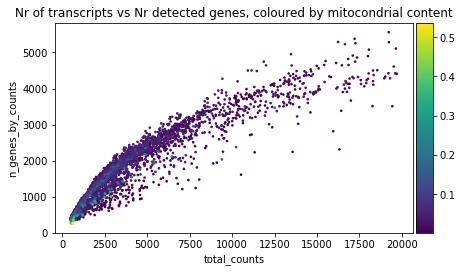

In [8]:
sc.pl.scatter(crypto_1[ crypto_1.obs['total_counts']<MAX_COUNTS ], 
              x='total_counts', y='n_genes_by_counts', color='perc_mito',
              title ='Nr of transcripts vs Nr detected genes, coloured by mitocondrial content')

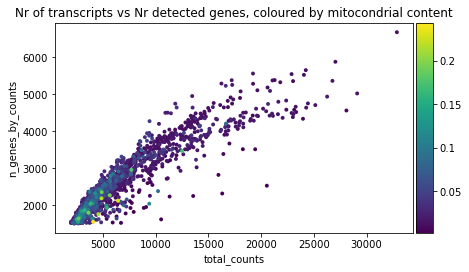

In [9]:
sc.pl.scatter(crypto_1[ crypto_1.obs['n_genes_by_counts'] > MIN_GENES ], 
              x='total_counts', y='n_genes_by_counts', color='perc_mito',
              title ='Nr of transcripts vs Nr detected genes, coloured by mitocondrial content')

In [10]:
sc.preprocessing.filter_cells(crypto_1, max_counts=MAX_COUNTS)

sc.preprocessing.filter_cells(crypto_1, min_counts=MIN_COUNTS)

sc.preprocessing.filter_cells(crypto_1, min_genes=MIN_GENES)

sc.preprocessing.filter_cells(crypto_1, max_genes=MAX_GENES)

sc.preprocessing.filter_genes(crypto_1, min_cells=10)

crypto_1 = crypto_1[crypto_1.obs['perc_mito']<MAX_MITO].copy()

In [11]:
crypto_1

AnnData object with n_obs × n_vars = 871 × 17834
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'perc_mito', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    layers: 'umi_raw'

<AxesSubplot:>

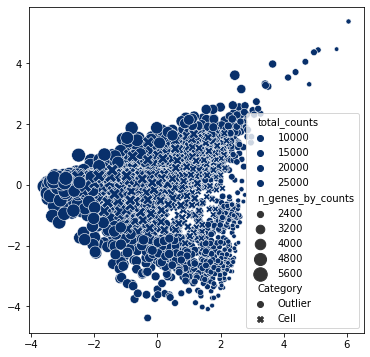

In [20]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.ensemble import IsolationForest

df = crypto_1.obs[ ['n_genes_by_counts', 'total_counts', 
                    'perc_mito', 'pct_counts_in_top_50_genes'] ]

df2 = scale(df, axis=0)

pca = PCA(n_components=2)

Y = pca.fit_transform(df2)

clf = IsolationForest(random_state=0, contamination=.1)

pred = clf.fit_predict(df2)

pred = pd.Categorical(pred)
pred = pred.rename_categories(['Outlier','Cell'])
df['Category'] = pred

sns.scatterplot(Y[:,0],Y[:,1], hue = df.total_counts, 
                size=df.n_genes_by_counts, style = df.Category, 
                palette="Blues", sizes=(20, 200), hue_norm=(0, 100))

In [21]:
pred

['Outlier', 'Cell', 'Cell', 'Cell', 'Cell', ..., 'Cell', 'Cell', 'Cell', 'Cell', 'Cell']
Length: 3781
Categories (2, object): ['Outlier', 'Cell']

In [22]:
crypto_1 = crypto_1[pred=='Cell'].copy()

In [12]:
crypto_1

AnnData object with n_obs × n_vars = 871 × 17834
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'perc_mito', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    layers: 'umi_raw'

In [13]:
sc.external.pp.scrublet(crypto_1, expected_doublet_rate=0.06, threshold=.2, random_state=12345)

Detected doublet rate = 2.4%
Estimated detectable doublet fraction = 49.3%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 4.9%


<AxesSubplot:xlabel='doublet_score', ylabel='Density'>

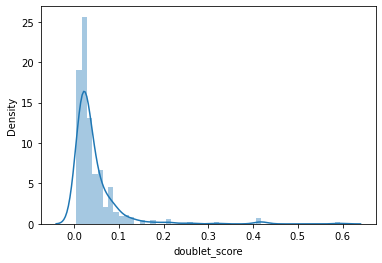

In [14]:
sns.distplot(crypto_1.obs['doublet_score'])

In [15]:
crypto_1 = crypto_1[np.invert(crypto_1.obs['predicted_doublet'])].copy()

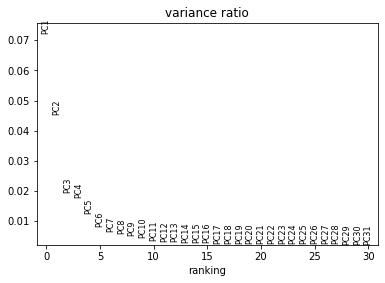

In [16]:
# TPM normalization and matrix copy
sc.pp.normalize_per_cell(crypto_1)
crypto_1.layers['umi_tpm'] = crypto_1.X.copy()

# matrix logarithmization and copy
sc.pp.log1p(crypto_1)
crypto_1.layers['umi_log'] = crypto_1.X.copy()

sc.pp.highly_variable_genes(crypto_1, n_top_genes=15000)

crypto_1.write('../../../Data/notebooks_data/crypto_1.filt.h5ad')

# standardized gene expressions and matrix copy
sc.pp.scale(crypto_1)
crypto_1.layers['umi_gauss'] = crypto_1.X.copy()

sc.preprocessing.pca(crypto_1, svd_solver='arpack', random_state=12345)

crypto_1

sc.plotting.pca_variance_ratio(crypto_1)

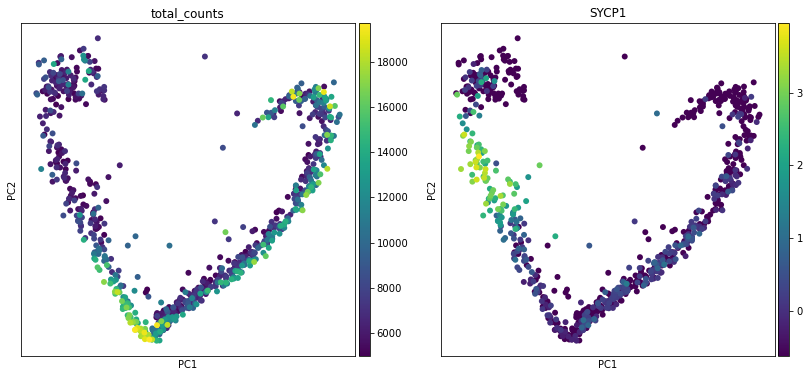

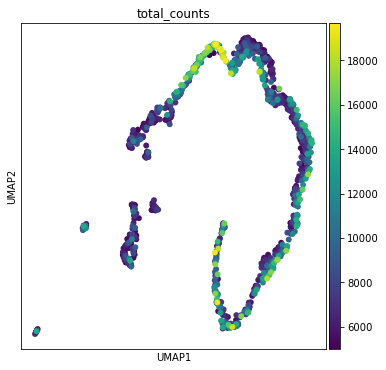

In [17]:
plt.rcParams['figure.figsize'] = (6,6) #reduce figure size
sc.pl.pca(crypto_1, color=['total_counts','SYCP1'])

sc.pp.neighbors(crypto_1, n_pcs=15)

sc.tools.umap(crypto_1, random_state=54321, n_components=2)

sc.plotting.umap(crypto_1, color=['total_counts'])

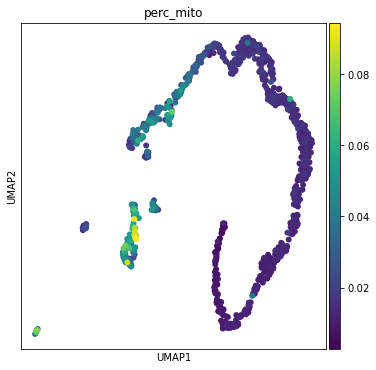

In [18]:
sc.plotting.umap(crypto_1, color=['perc_mito'])